<a href="https://colab.research.google.com/github/Tecnologias-Emergentes-Equipo2/ProyectoFinal/blob/main/ProyectoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final: Clasificación de Tumores Cerebrales Mediante el Uso de ResNet50

## 1. Exploración de los Datos

Se monta el drive de Google y se crea un link simbólico a la carpeta que contiene los datos que se usarán para entrenar y probar el modelo.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ln -s /content/gdrive/Shareddrives/Tecnologías\ Emergentes/Proyecto\ Final /proyecto
!ls /proyecto

 data  'Proyecto Final'   ProyectoFinal.ipynb


Función auxiliar que sirve para mostrar las imágenes en la Notebook.

In [ ]:
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

Se importa al ambiente virtual de Google el archivo zip que contiene los datos y se infla para utilizar los archivos.

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

In [ ]:
!cp /proyecto/data/archive.zip ./
!unzip archive.zip -d data/

Archive:  archive.zip
  inflating: data/Testing/glioma_tumor/image(1).jpg  
  inflating: data/Testing/glioma_tumor/image(10).jpg  
  inflating: data/Testing/glioma_tumor/image(100).jpg  
  inflating: data/Testing/glioma_tumor/image(11).jpg  
  inflating: data/Testing/glioma_tumor/image(12).jpg  
  inflating: data/Testing/glioma_tumor/image(13).jpg  
  inflating: data/Testing/glioma_tumor/image(14).jpg  
  inflating: data/Testing/glioma_tumor/image(15).jpg  
  inflating: data/Testing/glioma_tumor/image(16).jpg  
  inflating: data/Testing/glioma_tumor/image(17).jpg  
  inflating: data/Testing/glioma_tumor/image(18).jpg  
  inflating: data/Testing/glioma_tumor/image(19).jpg  
  inflating: data/Testing/glioma_tumor/image(2).jpg  
  inflating: data/Testing/glioma_tumor/image(20).jpg  
  inflating: data/Testing/glioma_tumor/image(21).jpg  
  inflating: data/Testing/glioma_tumor/image(22).jpg  
  inflating: data/Testing/glioma_tumor/image(23).jpg  
  inflating: data/Testing/glioma_tumor/image

Ejemplo de una imágen del dataset:

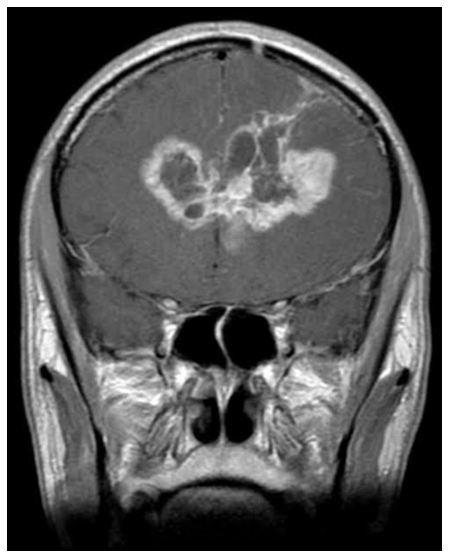

In [ ]:
imShow('data/Testing/glioma_tumor/image(1).jpg')

Se crea una carpeta para el set de validación, dividida en subcarpetas por cada tipo de tumor que contiene el dataset.

In [ ]:
!mkdir data/Validation/
%cd data/Validation
!mkdir glioma_tumor meningioma_tumor no_tumor pituitary_tumor
%cd ../
!ls Validation

/content/data/Validation
/content/data
glioma_tumor  meningioma_tumor	no_tumor  pituitary_tumor


Se crean listas que contienen las direcciones a las imágenes del set de entrenamiento para dividirlo en set de entrenamiento y validación.

In [ ]:
names = sorted( [fldr for fldr in os.listdir('Training')] )
folders = sorted( [os.path.join('Training', fldr) for fldr in os.listdir('Training')] )
vals = dict()

for i in range(len(folders)):
  temp = sorted( [os.path.join(folders[i], img) for img in os.listdir(folders[i])] )
  _, vals[names[i]] = train_test_split(temp, test_size=0.5, random_state=1110)

print("Ejemplo de archivos de validación:")
vals[names[0]][:3]

Ejemplo de archivos de validación:


['Training/glioma_tumor/gg (178).jpg',
 'Training/glioma_tumor/gg (502).jpg',
 'Training/glioma_tumor/gg (258).jpg']

Se mueven las imágenes que están contenidas en cada una de las listas para cada tumor a su equivalente dentro de la carpeta de validación.

In [ ]:
for folder, archivos in vals.items():
  for archivo in archivos:
    try:
      shutil.move(archivo, ''.join(['Validation/', folder, '/']))
    except:
      print(archivo)
      assert False

Cabe mencionar que el dataset cuenta con una cantidad dispareja de imágenes para cada clase, siendo la clase de `no_tumor` aproximadamente la mitad de grande que las demás clases, por lo que se ha optado por removerse la categoría de no tumor del dataset y del enfoque del proyecto, que es la clasificación de diferentes tipos de tumor.

In [ ]:
%cd ../
!ls data/Validation/no_tumor | wc -l

/content
198


In [ ]:
!ls data/Validation/meningioma_tumor | wc -l

411


In [ ]:
!rm -R data/Training/no_tumor/ data/Validation/no_tumor/ data/Testing/no_tumor/
!ls data/Testing/

glioma_tumor  meningioma_tumor	pituitary_tumor


In [ ]:
!ls data/

Testing  Training  Validation


## 2. Entrenamiento de ResNet

In [ ]:
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
img_height,img_width = (224,224)
batch_size = 32

train_data_dir = "data/Training"
valid_data_dir = "data/Validation"
test_data_dir = "data/Testing"


In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.4)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_height,img_width),
    batch_size = batch_size,
    class_mode ='categorical',
    subset='training'
)

valid_generator = train_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 743 images belonging to 3 classes.
Found 494 images belonging to 3 classes.


In [ ]:
test_generator = train_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height,img_width),
    batch_size=1,
    class_mode='categorical',
    subset='validation'
)

Found 115 images belonging to 3 classes.


In [ ]:
x,y = test_generator.next()
x.shape

(1, 224, 224, 3)

In [ ]:
base_model = ResNet50(include_top=False,weights='imagenet')
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
predictions = Dense(train_generator.num_classes,activation='softmax')(x)
model = Model(inputs=base_model.input,outputs=predictions)

for layer in base_model.layers:
  layer.trainable = False

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(train_generator,epochs=10)

94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/10
24/24 [==============================] - 25s 507ms/step - loss: 1.4524 - accuracy: 0.6299
Epoch 2/10
24/24 [==============================] - 12s 507ms/step - loss: 0.4277 - accuracy: 0.8318
Epoch 3/10
24/24 [==============================] - 12s 498ms/step - loss: 0.3347 - accuracy: 0.8829
Epoch 4/10
24/24 [==============================] - 12s 502ms/step - loss: 0.2632 - accuracy: 0.9004
Epoch 5/10
24/24 [==============================] - 12s 500ms/step - loss: 0.2194 - accuracy: 0.9179
Epoch 6/10
24/24 [==============================] - 12s 493ms/step - loss: 0.2080 - accuracy: 0.9179
Epoch 7/10
24/24 [==============================] - 12s 510ms/step - loss: 0.2141 - accuracy: 0.9166
Epoch 8/10
24/24 [==============================] - 12s 500ms/step - loss: 0.2178 - accuracy: 0.9219
Epoch 9/10
24/24 [==============================] - 12s 502ms/step - loss: 0.2134 - accuracy: 0.9058
Epoch 10/10
24/24 [=======

In [ ]:
model.save('data/Modelo.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
test_loss,test_acc =model.evaluate(test_generator,verbose=2)
print('\nTest accuracy:',test_acc)


115/115 - 5s - loss: 1.7428 - accuracy: 0.5130 - 5s/epoch - 42ms/step

Test accuracy: 0.5130434632301331


In [ ]:
import pandas as pd
import seaborn as sn
import tensorflow as tf


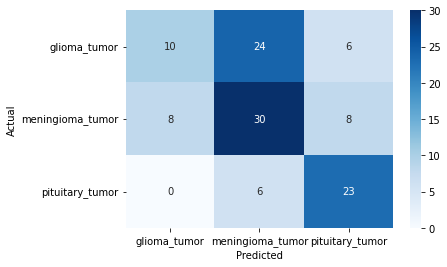

Test accuracy: 54.78260869565217


In [ ]:
model = tf.keras.models.load_model('data/Modelo.h5')
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
  X_test,Y_test =test_generator.next()
  y_prob.append(model.predict(X_test))
  y_act.append(Y_test)

predicted_class =[list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]


out_df  = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'],rownames=['Actual'],colnames=['Predicted'])

sn.heatmap(confusion_matrix,cmap='Blues',annot=True,fmt = 'd')
plt.show()
print('Test accuracy: {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))